In [2]:
import sys,os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import re, glob
import monai
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(seed=42) 

In [2]:
# !python -m pip install 'monai[all]'

In [26]:
%%time
DATADIR = "/DATA/Users/amahmood/braintyp/"

val_file_list = [{"image": x} for x in glob.glob(os.path.join(DATADIR,"val/*"))]
train_file_list = [{"image": x} for x in glob.glob(os.path.join(DATADIR,"train/*"))]

# DATADIR = "/DATA/ABCDFixRelease"
# val_file_list[:4], len(val_file_list)

CPU times: user 18.2 ms, sys: 21.5 ms, total: 39.7 ms
Wall time: 300 ms


In [34]:
from monai.data import CacheDataset, DataLoader, ArrayDataset
from monai.transforms import *

lambd = Lambda(func=lambda x: x[:, :, :,0,:])

img_transform = Compose(
    [
        LoadImaged("image", image_only=True),
        SqueezeDimd("image",dim=3),
        AsChannelFirstd("image"),
        SpatialCropd("image", roi_start=[11,   9,   0], roi_end=[172, 205, 152]),
        DivisiblePadd("image", k=8),
        RandAdjustContrastd("image")
    ]
)

ds = CacheDataset(val_file_list[:4], transform = img_transform)
arrds = ArrayDataset(val_file_list[:4], img_transform = img_transform)

Loading dataset: 100%|██████████| 4/4 [00:01<00:00,  2.58it/s]


In [29]:
x = ds[1]["image"]
nchannels, input_shape = x.shape[0], x.shape[1:]

In [30]:
nchannels, input_shape

(2, (168, 200, 152))

In [66]:
ds_loader = DataLoader(ds, batch_size=2, shuffle=False)
arrds_loader = DataLoader(arrds, batch_size=2, shuffle=False)

In [72]:
def inf_iter(data_loader):

    data_iter = iter(data_loader)

    while True:
        try:
            data = next(data_iter) 
        except StopIteration:
            # StopIteration is thrown if dataset ends
            # reinitialize data loader 
            data_iter = iter(data_loader)
            data = next(data_iter)
        yield data

In [82]:
ds_iter = inf_iter(ds_loader)

In [89]:
%%time
x = next(ds_iter)["image"]
# print(x.shape)

CPU times: user 961 ms, sys: 381 ms, total: 1.34 s
Wall time: 425 ms


In [95]:
isinstance(ds_loader, monai.data.dataloader.DataLoader)

True

In [97]:
isinstance(ds_loader, torch.utils.data.DataLoader)

True

In [93]:
%%time
batch = (
            torch.from_numpy(next(ds_iter)["image"]._numpy())
            .to(config.device)
            .float()
        )

AttributeError: 'Tensor' object has no attribute '_numpy'

In [77]:
 218//16 a*b+2*b

13

In [9]:
z = torch.zeros(2,1,5,5,5)
std = torch.randn(1)
z.shape, std.shape, (z*std[:]).shape

(torch.Size([2, 1, 5, 5, 5]), torch.Size([1]), torch.Size([2, 1, 5, 5, 5]))

In [17]:
def plot_slices(x):
    
    if isinstance(x, torch.Tensor):
        x = x.permute(0, 2, 3, 4, 1).detach().cpu().numpy()
    
    plt.subplots(3, 3, figsize=(8, 8))
    s = x.shape[2] // 16
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(x[0, :, (i+2)*s, :, 0], cmap="gray")
    plt.tight_layout()
    plt.show()
    return

In [11]:
!pwd

/home/braintyp/dataset


In [12]:
x = np.load("../workdir/brain/samples/iter_1/sample.np")
x.shape

(2, 128, 128, 128, 2)

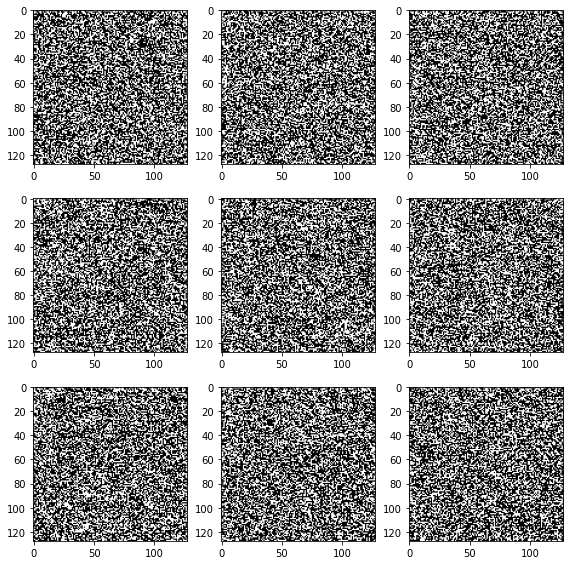

In [18]:
plot_slices(x)

In [78]:
from monai.networks.nets import SegResNet
from torchinfo import summary

resnet = SegResNet(in_channels=2, out_channels=2)
summary(resnet)

Layer (type:depth-idx)                   Param #
SegResNet                                --
├─ReLU: 1-1                              --
├─Convolution: 1-2                       --
│    └─Conv3d: 2-1                       432
├─ModuleList: 1-3                        --
│    └─Sequential: 2-2                   --
│    │    └─Identity: 3-1                --
│    │    └─ResBlock: 3-2                3,488
│    └─Sequential: 2-3                   --
│    │    └─Convolution: 3-3             3,456
│    │    └─ResBlock: 3-4                13,888
│    │    └─ResBlock: 3-5                13,888
│    └─Sequential: 2-4                   --
│    │    └─Convolution: 3-6             13,824
│    │    └─ResBlock: 3-7                55,424
│    │    └─ResBlock: 3-8                55,424
│    └─Sequential: 2-5                   --
│    │    └─Convolution: 3-9             55,296
│    │    └─ResBlock: 3-10               221,440
│    │    └─ResBlock: 3-11               221,440
│    │    └─ResBlock: 3-12    

In [84]:
h = resnet(x)
h.shape

torch.Size([1, 2, 184, 224, 184])

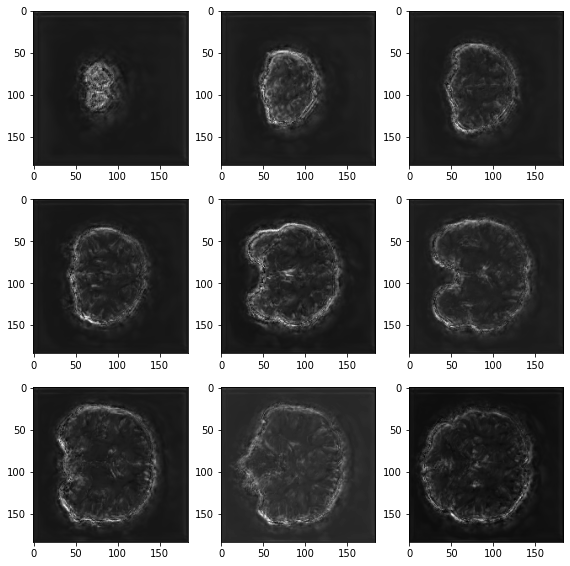

In [107]:
plot_slices(h)

In [17]:
from monai.networks.blocks import ResBlock, SABlock
import torch
import torch.nn as nn
from typing import Tuple, Union, Any

def variance_scaling(scale, mode, distribution,
                     in_axis=1, out_axis=0,
                     dtype=torch.float32,
                     device='cpu'):
  """Ported from JAX. """

  def _compute_fans(shape, in_axis=1, out_axis=0):
    receptive_field_size = np.prod(shape) / shape[in_axis] / shape[out_axis]
    fan_in = shape[in_axis] * receptive_field_size
    fan_out = shape[out_axis] * receptive_field_size
    return fan_in, fan_out

  def init(shape, dtype=dtype, device=device):
    fan_in, fan_out = _compute_fans(shape, in_axis, out_axis)
    if mode == "fan_in":
      denominator = fan_in
    elif mode == "fan_out":
      denominator = fan_out
    elif mode == "fan_avg":
      denominator = (fan_in + fan_out) / 2
    else:
      raise ValueError(
        "invalid mode for variance scaling initializer: {}".format(mode))
    variance = scale / denominator
    if distribution == "normal":
      return torch.randn(*shape, dtype=dtype, device=device) * np.sqrt(variance)
    elif distribution == "uniform":
      return (torch.rand(*shape, dtype=dtype, device=device) * 2. - 1.) * np.sqrt(3 * variance)
    else:
      raise ValueError("invalid distribution for variance scaling initializer")

  return init


def default_init(scale=1.):
  """The same initialization used in DDPM."""
  scale = 1e-10 if scale == 0 else scale
  return variance_scaling(scale, 'fan_avg', 'uniform')

def make_dense_layer(in_sz, out_sz):
    dense = nn.Linear(in_sz, out_sz)
    dense.weight.data = default_init()(dense.weight.shape)
    nn.init.zeros_(dense.bias)
    return dense

class SegResBlockpp(nn.Module):
    """
    ResBlock employs skip connection and two convolution blocks and is used
    in SegResNet based on `3D MRI brain tumor segmentation using autoencoder regularization
    <https://arxiv.org/pdf/1810.11654.pdf>`_.
    """
    
    def __init__(
        self,
        spatial_dims: int,
        in_channels: int,
        norm: Union[Tuple, str],
        kernel_size: int = 3,
        temb_dim: int = None,
        pre_conv: Any = None
    ) -> None:
        
        super().__init__()
        
        self.pre_conv = pre_conv
        self.resblock = ResBlock(
                        spatial_dims, in_channels, norm
        )
        
        if temb_dim is not None:
            self.dense = make_dense_layer(temb_dim, in_channels)

        self.act = nn.SiLU()
        
    def forward(self, x, temb=None):
        
        if self.pre_conv is not None:
            x = self.pre_conv(x)
        
        x = self.resblock(x)
        
        # If time embedding provided
        # Conditioning is acheived by adding time embedding
        # as a bias
        if temb is not None:
            b = self.dense(self.act(temb))[:, :, None, None, None]
            x += b
        
        return x
    
class GaussianFourierProjection(nn.Module):
    """Gaussian Fourier embeddings for noise levels."""

    def __init__(self, embedding_size=256, scale=1.0):
        super().__init__()
        self.W = nn.Parameter(torch.randn(embedding_size) * scale, requires_grad=False)

    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        # print("x:", x.shape, "x_proj:", x_proj.shape)
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

In [18]:
embed_dim = 128
embedder = GaussianFourierProjection(embedding_size=embed_dim)

blockpp = SegResBlockpp(
    spatial_dims=3,
    in_channels=2,
    norm= ("GROUP", {"num_groups": 2}),
    temb_dim = embed_dim * 2
)
block = nn.Sequential(blockpp)

In [148]:
t = torch.randn(x.shape[0])
t.shape

torch.Size([2])

In [145]:
t = torch.randn(x.shape[0])
for _ in range(len(x.shape)-1):
    t = torch.unsqueeze(t,dim=-1)
t.shape

torch.Size([2, 1, 1, 1, 1])

In [20]:
temb = embedder(torch.log(t))
temb.shape

torch.Size([2, 256])

In [83]:
from monai.networks.nets import ViT

img = torch.zeros((2,16,17,15,17))

In [84]:
vit = ViT(in_channels=16, img_size=(17,15,17), patch_size=(4,4,4), num_layers=2, num_heads=4,
          hidden_size=768, mlp_dim=3072, pos_embed='conv', classification=False, dropout_rate=0.0)
vit

ViT(
  (patch_embedding): PatchEmbeddingBlock(
    (patch_embeddings): Conv3d(16, 768, kernel_size=(4, 4, 4), stride=(4, 4, 4))
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (blocks): ModuleList(
    (0): TransformerBlock(
      (mlp): MLPBlock(
        (linear1): Linear(in_features=768, out_features=3072, bias=True)
        (linear2): Linear(in_features=3072, out_features=768, bias=True)
        (fn): GELU()
        (drop1): Dropout(p=0.0, inplace=False)
        (drop2): Dropout(p=0.0, inplace=False)
      )
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): SABlock(
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (qkv): Linear(in_features=768, out_features=2304, bias=False)
        (drop_output): Dropout(p=0.0, inplace=False)
        (drop_weights): Dropout(p=0.0, inplace=False)
      )
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (1): TransformerBlock(
      (mlp): MLPBlock(
     

In [88]:
h = vit(img)
[len(_h) for _h in h]

[2, 2]

In [92]:
h[0].shape

torch.Size([2, 48, 768])

In [95]:
h[1][0].shape, h[1][1].shape

(torch.Size([2, 48, 768]), torch.Size([2, 48, 768]))

In [74]:
attention = SABlock(32, num_heads = 4)
attention

SABlock(
  (out_proj): Linear(in_features=32, out_features=32, bias=True)
  (qkv): Linear(in_features=32, out_features=96, bias=False)
  (drop_output): Dropout(p=0.0, inplace=False)
  (drop_weights): Dropout(p=0.0, inplace=False)
)

In [75]:
attW = attention(img)
attW.shape

EinopsError:  Error while processing rearrange-reduction pattern "b h (qkv l d) -> qkv b l h d".
 Input tensor shape: torch.Size([2, 16, 16, 96]). Additional info: {'qkv': 3, 'l': 4}.
 Expected 3 dimensions, got 4

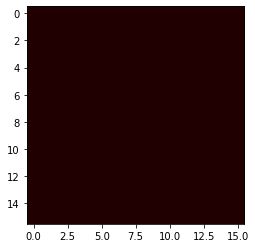

In [42]:
plt.imshow(attW.detach().numpy()[...,:3])

In [87]:
h = blockpp(x,temb)
h.shape

torch.Size([1, 2, 184, 224, 184])

In [111]:
# plot_slices(h)

In [130]:
class mySequential(nn.Sequential):
    def forward(self, *inputs):
        for module in self._modules.values():
            if type(inputs) == tuple:
                print(f"processing tuple of size {len(inputs)}")
                inputs = module(*inputs)
            else:
                inputs = module(inputs)
        return inputs
    
# class mySequential(nn.Sequential):
#     def forward(self, *inputs):
#         for module in self._modules.values():
#             inputs = module(*inputs)
#         return inputs

In [131]:
from typing import Optional, Sequence, Tuple, Union

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from monai.networks.blocks.segresnet_block import ResBlock, get_conv_layer, get_upsample_layer
from monai.networks.layers.factories import Dropout
from monai.networks.layers.utils import get_act_layer, get_norm_layer
from monai.utils import UpsampleMode

from torchinfo import summary

class SegResNetpp(nn.Module):
    """
    Time condioned version of SegResNet based on `3D MRI brain tumor segmentation using autoencoder regularization
    <https://arxiv.org/pdf/1810.11654.pdf>`_.
    The module does not include the variational autoencoder (VAE).
    
    Args:
        spatial_dims: spatial dimension of the input data. Defaults to 3.
        init_filters: number of output channels for initial convolution layer. Defaults to 8.
        in_channels: number of input channels for the network. Defaults to 1.
        out_channels: number of output channels for the network. Defaults to 2.
        dropout_prob: probability of an element to be zero-ed. Defaults to ``None``.
        act: activation type and arguments. Defaults to ``RELU``.
        norm: feature normalization type and arguments. Defaults to ``GROUP``.
        norm_name: deprecating option for feature normalization type.
        num_groups: deprecating option for group norm. parameters.
        use_conv_final: if add a final convolution block to output. Defaults to ``True``.
        blocks_down: number of down sample blocks in each layer. Defaults to ``[1,2,2,4]``.
        blocks_up: number of up sample blocks in each layer. Defaults to ``[1,1,1]``.
        upsample_mode: [``"deconv"``, ``"nontrainable"``, ``"pixelshuffle"``]
            The mode of upsampling manipulations.
            Using the ``nontrainable`` modes cannot guarantee the model's reproducibility. Defaults to``nontrainable``.

            - ``deconv``, uses transposed convolution layers.
            - ``nontrainable``, uses non-trainable `linear` interpolation.
            - ``pixelshuffle``, uses :py:class:`monai.networks.blocks.SubpixelUpsample`.

    """

    def __init__(
        self,
        spatial_dims: int = 3,
        init_filters: int = 8,
        in_channels: int = 1,
        out_channels: int = 2,
        dropout_prob: Optional[float] = None,
        act: Union[Tuple, str] = ("RELU", {"inplace": True}),
        norm: Union[Tuple, str] = ("GROUP", {"num_groups": 8}),
        norm_name: str = "",
        num_groups: int = 8,
        use_conv_final: bool = True,
        blocks_down: tuple = (1, 2, 2, 4),
        blocks_up: tuple = (1, 1, 1),
        upsample_mode: Union[UpsampleMode, str] = UpsampleMode.NONTRAINABLE,
        time_embedding_sz: int = 1024,
    ):
        super().__init__()

        if spatial_dims not in (2, 3):
            raise AssertionError("spatial_dims can only be 2 or 3.")

        self.spatial_dims = spatial_dims
        self.init_filters = init_filters
        self.in_channels = in_channels
        self.time_embedding_sz = time_embedding_sz
        self.blocks_down = blocks_down
        self.blocks_up = blocks_up
        self.dropout_prob = dropout_prob
        self.act = get_act_layer(act)
        if norm_name:
            if norm_name.lower() != "group":
                raise ValueError(f"Deprecating option 'norm_name={norm_name}', please use 'norm' instead.")
            norm = ("group", {"num_groups": num_groups})
        self.norm = norm
        self.upsample_mode = UpsampleMode(upsample_mode)
        self.use_conv_final = use_conv_final
        self.convInit = get_conv_layer(spatial_dims, in_channels, init_filters)
        self.down_layers = self._make_down_layers()
        self.up_layers, self.up_samples = self._make_up_layers()
        self.conv_final = self._make_final_conv(out_channels)
        self.time_embed_layer = self._make_time_cond_layers()
        self.attention_block = SABlock(init_filters * 2 ** len(blocks_down), num_heads = 8)

        if dropout_prob is not None:
            self.dropout = Dropout[Dropout.DROPOUT, spatial_dims](dropout_prob)
    
    
    def _make_time_cond_layers(self):
            
        sz = self.time_embedding_sz

        projection = GaussianFourierProjection(embedding_size=sz//4)
        # Projection layerdoubles the input_sz
        # Since it concats sin and cos projections 
        dense_0 = make_dense_layer(sz//2, sz)
        dense_1 = make_dense_layer(sz, sz)

        return nn.Sequential(projection, dense_0, dense_1)
    
    def _make_down_layers(self):
        down_layers = nn.ModuleList()
        blocks_down, spatial_dims, filters, norm, temb_dim = (
            self.blocks_down,
            self.spatial_dims,
            self.init_filters,
            self.norm,
            self.time_embedding_sz
        )
        for i in range(len(blocks_down)):
            layer_in_channels = filters * 2 ** i
            pre_conv = ( #PUSH THIS INTO THE Res++ Block
                get_conv_layer(spatial_dims, layer_in_channels // 2, layer_in_channels, stride=2)
                if i > 0
                else nn.Identity()
            )
            down_layer = mySequential( # First layer needs the preconv
                SegResBlockpp(spatial_dims, layer_in_channels, norm=norm, pre_conv=pre_conv, temb_dim=temb_dim), 
                *[SegResBlockpp(spatial_dims, layer_in_channels, norm=norm, pre_conv=None, temb_dim=temb_dim) for _ in range(blocks_down[i]-1)],
            )
            down_layers.append(down_layer)
        
        # TODO: Add some kind of attention block
        
        return down_layers

    def _make_up_layers(self):
        up_layers, up_samples = nn.ModuleList(), nn.ModuleList()
        upsample_mode, blocks_up, spatial_dims, filters, norm, temb_dim = (
            self.upsample_mode,
            self.blocks_up,
            self.spatial_dims,
            self.init_filters,
            self.norm,
            self.time_embedding_sz
        )
        n_up = len(blocks_up)
        for i in range(n_up):
            sample_in_channels = filters * 2 ** (n_up - i)
            up_layers.append(
                mySequential(
                    *[SegResBlockpp(spatial_dims, sample_in_channels // 2, norm=norm, temb_dim=temb_dim) for _ in range(blocks_up[i])]
                )
            )
            up_samples.append(
                nn.Sequential(
                    *[
                        get_conv_layer(spatial_dims, sample_in_channels, sample_in_channels // 2, kernel_size=1),
                        get_upsample_layer(spatial_dims, sample_in_channels // 2, upsample_mode=upsample_mode),
                    ]
                )
            )
        return up_layers, up_samples

    def _make_final_conv(self, out_channels: int):
        return nn.Sequential(
            get_norm_layer(name=self.norm, spatial_dims=self.spatial_dims, channels=self.init_filters),
            self.act,
            get_conv_layer(self.spatial_dims, self.init_filters, out_channels, kernel_size=1, bias=True),
        )

    def forward(self, x, t):
        x = self.convInit(x)
        if self.dropout_prob is not None:
            x = self.dropout(x)

        down_x = []
        t = self.time_embed_layer(t)
        
        for i,down in enumerate(self.down_layers):
            x = down(x,t)
            print(f"Computed layer {i}: {x.shape}")
            down_x.append(x)

        down_x.reverse()

        for i, (up, upl) in enumerate(zip(self.up_samples, self.up_layers)):
            x = up(x) + down_x[i + 1]
            x = upl(x, t)
            print(f"Computed layer {i}: {x.shape}")

        if self.use_conv_final:
            x = self.conv_final(x)
        return x

In [132]:
net = SegResNetpp(in_channels=2, out_channels=2, init_filters=8)
summary(net)

Layer (type:depth-idx)                        Param #
SegResNetpp                                   --
├─ReLU: 1-1                                   --
├─Convolution: 1-2                            --
│    └─Conv3d: 2-1                            432
├─ModuleList: 1-3                             --
│    └─mySequential: 2-2                      --
│    │    └─SegResBlockpp: 3-1                11,688
│    └─mySequential: 2-3                      --
│    │    └─SegResBlockpp: 3-2                33,744
│    │    └─SegResBlockpp: 3-3                30,288
│    └─mySequential: 2-4                      --
│    │    └─SegResBlockpp: 3-4                102,048
│    │    └─SegResBlockpp: 3-5                88,224
│    └─mySequential: 2-5                      --
│    │    └─SegResBlockpp: 3-6                342,336
│    │    └─SegResBlockpp: 3-7                287,040
│    │    └─SegResBlockpp: 3-8                287,040
│    │    └─SegResBlockpp: 3-9                287,040
├─ModuleList: 1-4     

In [133]:
%%time
h = net(x,t)
h.shape

processing tuple of size 2
Computed layer 0: torch.Size([2, 8, 168, 200, 152])
processing tuple of size 2
Computed layer 1: torch.Size([2, 16, 84, 100, 76])
processing tuple of size 2
Computed layer 2: torch.Size([2, 32, 42, 50, 38])
processing tuple of size 2
Computed layer 3: torch.Size([2, 64, 21, 25, 19])
processing tuple of size 2
Computed layer 0: torch.Size([2, 32, 42, 50, 38])
processing tuple of size 2
Computed layer 1: torch.Size([2, 16, 84, 100, 76])
processing tuple of size 2
Computed layer 2: torch.Size([2, 8, 168, 200, 152])
CPU times: user 1min 2s, sys: 20.2 s, total: 1min 23s
Wall time: 5.25 s


torch.Size([2, 2, 168, 200, 152])

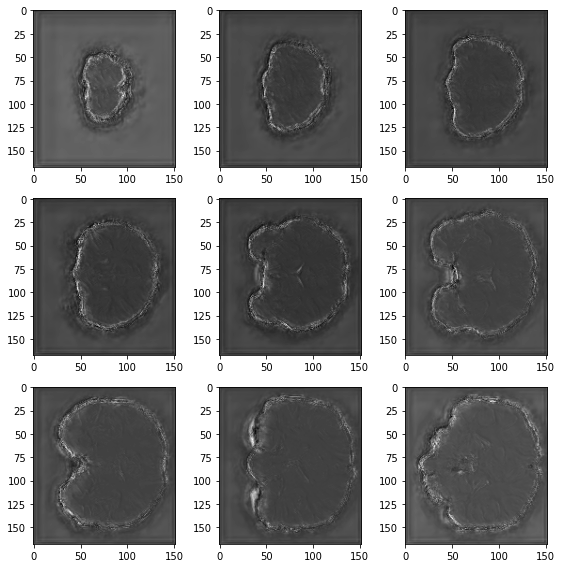

In [108]:
plot_slices(h)

In [50]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available(), x.device, device

(True, device(type='cpu'), device(type='cuda', index=0))

In [60]:
net.to(device)
x_gpu = torch.zeros(x.shape).to(device)
t_gpu = torch.zeros(x.shape[0]).to(device)
x_gpu.device

device(type='cuda', index=0)

In [61]:
%%time
h = net(x_gpu, t_gpu)
h.shape

CPU times: user 34.4 ms, sys: 36.2 ms, total: 70.6 ms
Wall time: 66.5 ms


torch.Size([2, 2, 184, 224, 184])

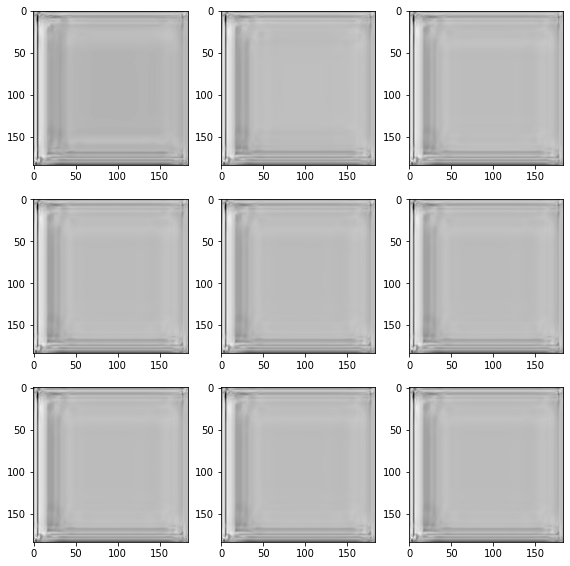

In [62]:
plot_slices(h)

In [ ]:
class ResnetBlock3Dpp(nn.Module):
    def __init__(
        self,
        act,
        in_ch,
        out_ch=None,
        temb_dim=None,
        up=False,
        down=False,
        dropout=0.1,
        fir=False,
        fir_kernel=(1, 3, 3, 1),
        skip_rescale=True,
        init_scale=0.0,
    ):
        super().__init__()

        out_ch = out_ch if out_ch else in_ch

        self.up = up
        self.down = down
        
        self.Conv_0 = conv3x3(in_ch, out_ch)
        
        self.block = ResBlock(
            
        spatial_dims=3,
            in_channels=2,
            norm= ("GROUP", {"num_groups": 2})
        )
        
        if temb_dim is not None:
            self.Dense_0 = nn.Linear(temb_dim, out_ch)
            self.Dense_0.weight.data = default_init()(self.Dense_0.weight.shape)
            nn.init.zeros_(self.Dense_0.bias)

        self.GroupNorm_1 = nn.GroupNorm(
            num_groups=min(out_ch // 4, 32), num_channels=out_ch, eps=1e-6
        )
        self.Dropout_0 = nn.Dropout(dropout)
        self.Conv_1 = conv3x3(out_ch, out_ch, init_scale=init_scale)
        if in_ch != out_ch or up or down:
            self.Conv_2 = conv1x1(in_ch, out_ch)

        self.skip_rescale = skip_rescale
        self.act = act
        self.in_ch = in_ch
        self.out_ch = out_ch

    def forward(self, x, temb=None):
        h = self.act(self.GroupNorm_0(x))

        if self.up:
            if self.fir:
                h = up_or_down_sampling.upsample_2d(h, self.fir_kernel, factor=2)
                x = up_or_down_sampling.upsample_2d(x, self.fir_kernel, factor=2)
            else:
                h = up_or_down_sampling.naive_upsample_2d(h, factor=2)
                x = up_or_down_sampling.naive_upsample_2d(x, factor=2)
        elif self.down:
            if self.fir:
                h = up_or_down_sampling.downsample_2d(h, self.fir_kernel, factor=2)
                x = up_or_down_sampling.downsample_2d(x, self.fir_kernel, factor=2)
            else:
                h = up_or_down_sampling.naive_downsample_2d(h, factor=2)
                x = up_or_down_sampling.naive_downsample_2d(x, factor=2)

        h = self.Conv_0(h)
        # Add bias to each feature map conditioned on the time embedding
        if temb is not None:
            h += self.Dense_0(self.act(temb))[:, :, None, None]
        h = self.act(self.GroupNorm_1(h))
        h = self.Dropout_0(h)
        h = self.Conv_1(h)

        if self.in_ch != self.out_ch or self.up or self.down:
            x = self.Conv_2(x)

        if not self.skip_rescale:
            return x + h
        else:
            return (x + h) / np.sqrt(2.0)
